# A.2 - Régression logistique

Dans le notebook précédent, nous avons étudié la **régression linéaire **: une technique permettant d'ajuster un modèle linéaire à un ensemble de points. Ce modèle repose sur l'hypothèse que la variable dépendante/expliquée (la quantité que nous cherchons à prédire par notre modèle) prend des valeurs **quantitatives**. Lorsque cette hypothèse n'est plus valable, ce qui est généralement le cas pour les valeurs **qualitatives**, la régression linéaire donne des résultats plutôt médiocres. Il en découle naturellement la nécessité d'utiliser la **régression non linéaire** (ajuster une fonction non linéaire aux données).

Dans ce notebook, nous présenterons la forme la plus simple de prédiction **qualitative**, à savoir la **classification binaire**. La principale différence par rapport à la régression linéaire réside dans les données elles-mêmes, et plus particulièrement dans les variables à predir, qui ne peuvent prendre que deux valeurs. Cette différence subtile est si importante qu'elle justifie le développement de nouvelles fonctions de coût mieux adaptées pour traiter de telles données. De plus, il existe un large éventail de fonctions de coût conçues pour la classification binaire, conduisant chacune à un modèle différent, comme la **régression logistique** (le sujet traité dans la suite), les machines à vecteurs de support, les réseaux de neurones, etc.

<!--
In the previous notebook, we discussed the fitting of a linear model to a set of input/output points, otherwise known as linear regression. This model relies on the assumption that the ouputs are **quantitative** values. When this assumption does not hold, which is typically the case for **qualitative** output values, linear regression performs rather poorly. This naturally leads to the exploration of fitting a nonlinear function to data, referred to in general as nonlinear regression.

In this notebook, we will introduce the simplest form of **qualitative** prediction, which is **binary classification**. The main difference with respect to linear regression lies in the data itself, and more particularly in its outputs, which can take on only one of two values. This subtle difference is important, and spurs the development of new cost functions that are better-suited to deal with such data. Moreover, these new cost functions are formulated based on a wide array of motivating perspectives, each leading to a different model, such as **logistic regression**, support vector machines, or neural networks.
-->


### Table des matières

- [1. Etude d'un problème de classification binaire](#1.-Etude-d'un-problème-de-classification-binaire)
    - [1.1 Récupération de la base de données](#1.1-Récupération-de-la-base-de-données)
    - [1.2 Apprentissage du modèle logistique](#1.2-Apprentissage-du-modèle-logistique)
    - [1.3 Validation du modèle](#1.3-Validation-du-modèle)
    

- [2. Exercices corrigés](#2.-Exercices-corrigés)
    - [2.1 Modèle logistique](#2.1-Modèle-logistique)
    - [2.2 Cotes (odds)](#2.2-Cotes-(odds))
    

- [3. The math behind logistic regression](#3.-The-math-behind-logistic-regression)
    - [3.1 Sigmoid Function](#3.1-Sigmoid-function)
    - [3.2 Logistic regression](#3.2-Logistic-regression)
    - [3.3 Logarithmic error](#3.3-Logarithmic-error)
    - [3.4 Logistic cost function](#3.4-Logistic-cost-function)
    - [3.5 Gradient descent](#3.5-Gradient-descent)

### Prérequis

Commençons par importer toutes les bibliotheques dont nous avons besoin dans le notebook.

- [Numpy](www.numpy.org) - Le paquet fondamental pour le calcul scientifique avec Python.
- [StatsModels](http://www.statsmodels.org/stable/index.html) - Récolte de nombreux modèles statistiques.
- [Pandas](https://pandas.pydata.org) - Tableaux numériques permettant de manipuler facilement les données.
- [Matplotlib](http://matplotlib.org) - Outils pour le traçage en 2D/3D et pour la réalisation d'animations.
- [Seaborn](https://seaborn.pydata.org/index.html) - Interface de haut niveau pour l'affichage de statistiques.

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.colors import LogNorm

import ipywidgets as widgets
from IPython.display import display
%matplotlib inline


## 1. Etude d'un problème de classification binaire

Dans de nombreux systèmes de justice pénale à travers le monde, les détenus qui ne sont pas considérés comme une menace pour la société sont libérés sous le régime de la libération conditionnelle avant d'avoir purgé leur peine. Cependant, ces individus demeurent tout de même sous la responsabilité du gouvernement jusqu'à l'expiration de leur sentence, et ils peuvent être renvoyés en prison s'ils enfreignent les conditions de leur libération conditionnelle. 

#### Objectif - Prédire la récidive des libérés conditionnels

Les commissions des libérations conditionnelles sont chargées de déterminer quels détenus sont de bons candidats à la libération conditionnelle. Ils cherchent à libérer les détenus qui ne commettront pas d'autres crimes après leur libération. Dans ce problème, notre but est de construire et valider un modèle qui prédit si un détenu violera les conditions de sa libération conditionnelle. Un tel modèle pourrait être utile à la commission des libérations conditionnelles lorsqu'elle décide d'approuver ou de rejeter une demande de libération conditionnelle.

#### Base de données

Pour cette tâche, nous utiliserons les données issues d'un recensement des libérations conditionnelles qui ont eu lieu aux États-Unis en 2004 . Nous nous limitons aux libérés conditionnels qui n'ont pas purgé plus de six mois en prison et dont la peine maximale pour toutes les accusations n'a pas dépassé 18 mois. L'ensemble de données comprend tous les détenus qui ont terminé avec succès leur période de libération conditionnelle en 2004, et ceux qui ont enfreint les conditions de leur libération conditionnelle en 2004.

La base de données contient les variables suivantes.

- **male**: 1 si le libéré conditionnel est un homme, 0 sinon.
- **race**: 1 si le libéré conditionnel est un blanc, 2 sinon.
- **age**: l'âge du libéré conditionnel (en années) à sa sortie de prison.
- **state**: un code pour le domicile du libéré conditionnel, où 2 est le Kentucky, 3 la Louisiane, 4 la Virginie et 1 tout autre état. Les trois états ont été choisis en raison de leur forte représentation dans l'ensemble de données.

- **time.served**: le nombre de mois que le libéré conditionnel a purgé en prison (limité par les critères d'inclusion à six mois au maximum).

- **max.sentence**: la durée maximale de la peine pour toutes les accusations, en mois (limitée par les critères d'inclusion à un maximum de 18 mois).

- **multiple.offenses**: 1 si le libéré conditionnel a été incarcéré pour plusieurs infractions, 0 sinon.

- **crime**: un code pour le crime principal du libéré conditionnel menant à l'incarcération, où 2 est le vol, 3 un crime lié à la drogue, 4 un crime lié à la conduite de voiture, et 1 tout autre crime.

- **violator**: 1 si le libéré conditionnel a enfreint les conditions de sa libération conditionnelle, et 0 si le libéré conditionnel a terminé sa libération sans enfreindre les conditions.

Le but est de prédire si le détenu est susceptible ou non de manquer de parole, c’est-à-dire de récidiver alors qu’il est en liberté conditionnelle sur parole.

<!--
In many criminal justice systems around the world, inmates deemed not to be a threat to society are released from prison under the parole system prior to completing their sentence. They are still considered to be serving their sentence while on parole, and they can be returned to prison if they violate the terms of their parole.
Parole boards are charged with identifying which inmates are good candidates for release on parole. They seek to release inmates who will not commit additional crimes after release. In this problem, we will build and validate a model that predicts if an inmate will violate the terms of his or her parole. Such a model could be useful to a parole board when deciding to approve or deny an application for parole.

For this prediction task, we will use data from the United States 2004 National Corrections Reporting Program, a nationwide census of parole releases that occurred during 2004. We limited our focus to parolees who served no more than 6 months in prison and whose maximum sentence for all charges did not exceed 18 months. The dataset contains all such parolees who either successfully completed their term of parole during 2004 or those who violated the terms of
their parole during that year. 

The dataset contains the following variables.

- **male**: 1 if the parolee is male, 0 if female
- **race**: 1 if the parolee is white, 2 otherwise
- **age**: the parolee's age (in years) when he or she was released from prison
- **state**: a code for the parolee's state. 2 is Kentucky, 3 is Louisiana, 4 is Virginia, and 1 is any other state. The three states were selected due to having a high representation in the dataset.
- **time.served**: the number of months the parolee served in prison (limited by the inclusion criteria to not exceed 6 months).
- **max.sentence**: the maximum sentence length for all charges, in months (limited by the inclusion criteria to not exceed 18 months).
- **multiple.offenses**: 1 if the parolee was incarcerated for multiple offenses, 0 otherwise.
- **crime**: a code for the parolee's main crime leading to incarceration. 2 is larceny, 3 is drug-related crime, 4 is driving related crime, and 1 is any other crime.
- **violator**: 1 if the parolee violated the parole, and 0 if the parolee completed the parole without violation.
-->

### 1.1 Récupération de la base de données 

Tout d'abord, nous chargeons les données du fichier `parole.csv` dans une **data frame** par la méthode `read_csv()`.

In [6]:
parole = pd.read_csv("parole.csv")
parole.head()

,male,race,age,state,time.served,max.sentence,multiple.offenses,crime,violator
0,1,1,33.2,1,5.5,18,0,4,0
1,0,1,39.7,1,5.4,12,0,3,0
2,1,2,29.5,1,5.6,12,0,3,0
3,1,1,22.4,1,5.7,18,0,1,0
4,1,2,21.6,1,5.4,12,0,1,0


### 1.1.1 Premières observations

Obtenir des informations générales sur la base de données en utilisant les fonctions appropriés du module `pandas`.

<div class="alert alert-info">

**Question 1** 

> Combien y a-t-il d’individus qui ont donné leur parole ?

</div>

*Resultat attendu:* 675

In [7]:
individus = parole.shape[0]

print('Nombre d\'individus dans la base:', individus)

Nombre d'individus dans la base: 675


<div class="alert alert-info">

**Question 2** 

> Quel est leur age moyen ?

</div>

*Resultat attendu:* 34.5

In [8]:
age_moyen = round(parole['age'].mean(), 1)

print('Age moyen:', age_moyen)

Age moyen: 34.5


<div class="alert alert-info">

**Question 3** 

> Quel est le pourcentage d’hommes ?

</div>

*Resultat attendu:* 80.74%

In [9]:
hommes = parole['male'].mean()

print('Proportion d\'hommes: {:2.2f} %'.format(hommes*100))

Proportion d'hommes: 80.74 %


<div class="alert alert-info">

**Question 4** 

> Combien de détenus ont récidivé (manqué à leur parole) ?

</div>

*Resultat attendu:* 11.56%

In [10]:
recidive = parole['violator'].mean()

print('Proportion de recidive: {:2.2f} %'.format(recidive*100))

Proportion de recidive: 11.56 %


La figure suivante montre le distribution des détenus par rapport à la variable `violator`.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


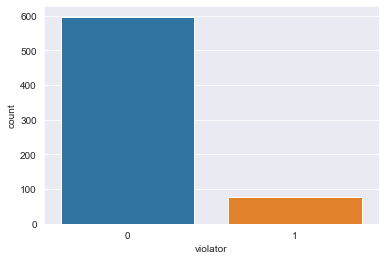

In [11]:
sns.countplot(x='violator', data=parole)
plt.show()

<div class="alert alert-info">

**Question 5** 

> Quelles sont les moyennes des durées de peines (variable `max.sentence`) pour ceux qui ont récidivé et pour les autres?

</div>

*Tuyau:* Utilisez la fonction `groupby()` pour grouper les observations par les valeurs d'une colonne, et puis manipuler chaque groupe de maniere appropriée. Voir ce [tutoriel](http://pbpython.com/pandas_transform.html) pour plus d'informations sur les groupes de pandas.

*Resultat attendu:* 11.6 mois pour ceux qui ont récidivé - 13.24 mois pour les autres.

In [12]:
durees_moyens = parole.groupby('violator')['max.sentence'].mean()

print('Durée moyenne des peines: {:2.2f} (recidives) et {:2.2f} (autres)'.format(durees_moyens[1],durees_moyens[0]))

Durée moyenne des peines: 11.63 (recidives) et 13.24 (autres)


### 1.1.2 Traitement des variables catégorielles

<div class="alert alert-info">

**Question 1** 

> Quelles sont, d’après la présentation ci-dessus, les variables catégorielles avec au moins trois catégories ?

</div>

*Remarque:* Il n'existe pas une procedure automatique pour detecter les variables categorielles dans une base de données. La raison est que les types de données sont orthogonaux aux variables catégorielles (discretes/ordinales/nominales). Par consequent, vous ne pourrez pas trouver la réponse à cette question par l'implementation d'un morceau de code python, mais plutot par l'inspection visuelle de la base de données.

In [13]:
variables_categorielle = ['state', 'crime']

print('Variables categorielles:', variables_categorielle)

Variables categorielles: ['state', 'crime']


<div class="alert alert-info">

**Question 2** 

> Quel est l’état le plus représenté ?

</div>

*Tuyau:* Uliliser les méthodes `value_counts()` et `idxmax()`.

*Resultat attendu:* Virginie

In [14]:
noms = {1: "Autre", 2: "Kentucky", 3: "Louisiane", 4: "Virginie"}

etat_max = parole['state'].value_counts().idxmax()

print('Etat le plus représenté:', noms[etat_max])

Etat le plus représenté: Virginie


<div class="alert alert-info">

**Question 3** 

> Quel est l’état le plus représenté pour ceux qui ont récidivé?

</div>

*Resultat attendu:* Louisiane

In [15]:
etat_max_recivide = parole.query('violator == 1')['state'].value_counts().idxmax()

print('Etat le plus représenté pour les recidives:', noms[etat_max_recivide])

Etat le plus représenté pour les recidives: Louisiane


<div class="alert alert-info">

**Question 4** 

> Modifier les colonnes `state` et `crime` pour qu’elles apparaissent comme variables catégorielles.

</div>

*Tuyau:* Utilisez la fonction `pd.get_dummies()`.

*Resultat attendu:* Les colonnes du nouveau data-frame sont
 - male, race, age, time.served, max.sentence, multiple.offenses;
 - violator;
 - state_1, state_2, state_3, state_4;
 - crime_1, crime_2, crime_3, crime_4.

In [16]:
parole_dummies = pd.get_dummies(parole, columns=variables_categorielle ,prefix_sep='_')

parole_dummies.head()

,male,race,age,time.served,max.sentence,multiple.offenses,violator,state_1,state_2,state_3,state_4,crime_1,crime_2,crime_3,crime_4
0,1,1,33.2,5.5,18,0,0,True,False,False,False,False,False,False,True
1,0,1,39.7,5.4,12,0,0,True,False,False,False,False,False,True,False
2,1,2,29.5,5.6,12,0,0,True,False,False,False,False,False,True,False
3,1,1,22.4,5.7,18,0,0,True,False,False,False,True,False,False,False
4,1,2,21.6,5.4,12,0,0,True,False,False,False,True,False,False,False


<div class="alert alert-info">

**Question 5**

> Eliminer les colonnes `state_1` et `crime_1` du data-frame.

</div>

*Tuyau:* Utilisez la fonction `pd.drop()`.

*Resultat attendu:* Les colonnes du nouveau data-frame sont
 - male, race, age, time.served, max.sentence, multiple.offenses;
 - violator;
 - state_2, state_3, state_4;
 - crime_2, crime_3, crime_4.

In [17]:
parole_dummies = parole_dummies.drop(['state_1', 'crime_1'], axis=1)

parole_dummies.head()

,male,race,age,time.served,max.sentence,multiple.offenses,violator,state_2,state_3,state_4,crime_2,crime_3,crime_4
0,1,1,33.2,5.5,18,0,0,False,False,False,False,False,True
1,0,1,39.7,5.4,12,0,0,False,False,False,False,True,False
2,1,2,29.5,5.6,12,0,0,False,False,False,False,True,False
3,1,1,22.4,5.7,18,0,0,False,False,False,False,False,False
4,1,2,21.6,5.4,12,0,0,False,False,False,False,False,False


<div class="alert alert-info">

**Question 6** 

> Remplacer la valeur `2` par la valeur `0` dans la colonne `race`.

</div>

*Tuyau:* Utilisez la fonction `pd.replace()`.

In [18]:
parole_dummies['race'] = parole_dummies['race'].replace(2, 0)

parole_dummies.head()

,male,race,age,time.served,max.sentence,multiple.offenses,violator,state_2,state_3,state_4,crime_2,crime_3,crime_4
0,1,1,33.2,5.5,18,0,0,False,False,False,False,False,True
1,0,1,39.7,5.4,12,0,0,False,False,False,False,True,False
2,1,0,29.5,5.6,12,0,0,False,False,False,False,True,False
3,1,1,22.4,5.7,18,0,0,False,False,False,False,False,False
4,1,0,21.6,5.4,12,0,0,False,False,False,False,False,False


### 1.1.3 Séparation des données

Avant d'effectuer tout prediction, il est imperatif que les données soient separées en deux sous ensembles:

- **Base d'apprentissage:** Elle contient les données pour construire le modèle de regression logistique.


- **Base de test:** Elle contient les données pour valider le modèle de regression logistique.

<div class="alert alert-info">

**Question 1** 

> A partir du data-frame `parole_dummies`, construir une base d'apprentissage avec le 70% des données, ainsi qu'une base de test avec le 30% restant. La proportion d'individus ayant récidivé doit etre respectée dans les deux bases.

</div>

*Tuyau:* Utiliser les méthodes `.sample(frac=..., random_state=10)` et `.drop(...)` de pandas.

In [19]:
train = parole_dummies.sample(frac=0.7, random_state=10)
test  = parole_dummies.drop(train.index)

train.head()

,male,race,age,time.served,max.sentence,multiple.offenses,violator,state_2,state_3,state_4,crime_2,crime_3,crime_4
277,1,1,30.7,2.2,12,0,0,False,False,False,False,True,False
548,0,0,32.4,3.8,14,1,0,False,False,True,False,True,False
211,0,0,51.4,4.2,6,1,1,False,True,False,False,True,False
585,1,1,36.5,5.5,18,0,0,False,False,True,False,False,False
429,1,1,40.1,3.7,14,1,0,False,False,True,False,False,False


<div class="alert alert-info">

**Question 2** 

> Quelle est le nombre d'individus dans la base de test ?

</div>

*Resultat attendu:* 203

In [20]:
individus_test = test.shape[0]

print('Individus dans la base de test:', individus_test)

Individus dans la base de test: 203


<div class="alert alert-info">

**Question 3** 

> La proportion d’individus ayant récidivé est-elle respectée dans les différentes bases ?

</div>

*Resultat attendu:* 11.23% dans la base d'apprentissage et 12.32% dans la base de test. 

*Remarques:* 
 - Les proportions peuvent varier legerement en fonction du paramètre `random_state` specifié dans la fonction `.sample()`. 
 - Dans notre corrigé, nous avons utilisé `random_state=10`. 

In [21]:
recidive_train = train['violator'].mean()
recidive_test  = test['violator'].mean()

print('Proportion de recidive (base d\'appr.): {:2.2f} %'.format(recidive_train*100))
print('Proportion de recidive (base de test): {:2.2f} %'.format(recidive_test*100))

Proportion de recidive (base d'appr.): 11.23 %
Proportion de recidive (base de test): 12.32 %


### 1.2 Apprentissage du modèle logistique

Maintenant, nous allons construire un modèle de classification binaire à partir de la bases d'apprentissage.

<div class="alert alert-info">

**Question 1** 

> Construire le modèle logistique à partir de toutes les variables dans la base d'apprentissage.

</div>

*Tuyau:* Utiliser la fonction `sm.GLM(y, X, family=sm.families.Binomial()).fit()` du package `statsmodels`. 
 - Le paramètre `y` est une data-frame avec la seule colonne `violator`.
 - Le paramètre `X` est une data-frame avec une colonne pour chaque autre variable à inclure dans le modèle.

In [22]:
X_train = train.drop('violator', axis=1)
X_train = sm.add_constant(X_train)
y_train = train['violator']

modele = sm.GLM(y_train, X_train.astype(float), family=sm.families.Binomial()).fit()

str(modele.summary())

'                 Generalized Linear Model Regression Results                  \n==============================================================================\nDep. Variable:               violator   No. Observations:                  472\nModel:                            GLM   Df Residuals:                      459\nModel Family:                Binomial   Df Model:                           12\nLink Function:                  Logit   Scale:                          1.0000\nMethod:                          IRLS   Log-Likelihood:                -126.85\nDate:                Sun, 26 Nov 2023   Deviance:                       253.71\nTime:                        16:05:34   Pearson chi2:                     432.\nNo. Iterations:                     7   Pseudo R-squ. (CS):             0.1521\nCovariance Type:            nonrobust                                         \n=====================================================================================\n                        coef    

<div class="alert alert-info">

**Question 2** 

> Quelles sont les variables les plus significatives ? 

</div>

*Tuyau:* Regarder les codes affichés par la fonction `important_variables()` (*** = variable significative).

*Reponse attendue:* multiple.offenses, state_4

In [23]:
def significant_variables(model):
    code = lambda x: '***' if x < 0.001 else '**' if x < 0.01 else '*' if x < 0.05 else '.' if x < 0.1 else ''
    df = pd.DataFrame(model.pvalues.transform(code), columns=[''])
    print(df)

In [24]:
significant_variables(modele)

                      
const                *
male                  
race                 *
age                   
time.served           
max.sentence          
multiple.offenses  ***
state_2               
state_3               
state_4            ***
crime_2               
crime_3               
crime_4               


### 1.2.1 Interpretation du modèle logistique

Rappellons que 

- les **chances (odds)** d'un détenu $x$ sont egales à

$$\mathsf{odds}(x) = \frac{{\sf P}({\rm violator}=1 \,|\, x)}{{\sf P}({\rm violator}=0 \,|\, x)} = \exp\big(w_0 + w_1 x_1 + \dots + w_Q x_Q\big)
$$

- le **logarithme des chances (logit)** d'un détenu $x$ est egal à

$$\mathsf{logit}(x) = \log\big(\mathsf{odds}(x)\big) = w_0 + w_1 x_1 + \dots + w_Q x_Q
$$

- la **probabilité de recidive** pour un détenu $x$ est egale à

$$
{\sf P}({\rm violator}=1 \,|\, x) = \textsf{sigmoid}\big(\mathsf{logit}(x)\big) = \frac{1}{1+e^{-\left(w_0 + w_1 x_1 + \dots + w_Q x_Q\right)}}
$$

Examinons le cas de la variable `multiple.offenses`.

<div class="alert alert-info">

**Question 1** 

> Quelle est la valeur de 
$$\mathsf{logit}(x_A) - \mathsf{logit}(x_B)$$
où 
- $x_A$ = détenu qui a commis de multiples crimes
- $x_B$ = détenu n'ayant commis qu'un crime, mais dont les autres variables sont identiques à $x_A$.

</div>

*Tuyau:* Les coefficients $w=(w_0,w_1,\dots,w_Q)$ du modèle sont stockés dans l'attribut `modele.params`

*Resultat attendu:* 1.32918...

In [25]:
logitA_moins_logitB = modele.params['multiple.offenses']

print('logit(A) - logit(B):', logitA_moins_logitB)

logit(A) - logit(B): 1.329187031875609


<div class="alert alert-info">

**Question 2** 

> En déduire le rapport entre les chances de $x_A$ et $x_B$, notamment
$$\frac{\mathsf{odds}(x_A)}{\mathsf{odds}(x_B)}.$$

</div>

*Tuyau:* Utiliser la fonction `np.exp()`

*Resultat attendu:* 3.77797...

In [26]:
pA_over_pB = np.exp(logitA_moins_logitB)

print('P(A) / P(B):', pA_over_pB)

P(A) / P(B): 3.7779707689574713


Considérons à présent le cas d’un détenu blanc, de sexe masculin, âgé de 50 ans, originaire de l’état de Maryland, ayant déjà accompli 3 mois de détention, qui n’a commis qu’un vol et a une peine maximale de 12 mois.

<div class="alert alert-info">

**Question 3** 

> Créer le vecteur $x=(x_0, x_1, x_2, \dots, x_{12})$ qui represente cet individu, en rajoutant $x_0=1$ au début pour l'intercept. 

</div>

*Tuyau:* Les variables du vecteur $x$ correspondent aux colonnes du data-frame `parole_dummies`:

- $x_0$ - **const** (toujours egale à 1)
- $x_1$ - **male** (1=homme, 0=femme)
- $x_2$ - **race** (1=blanc, 0=autre)
- $x_3$ - **age**
- $x_4$ - **time.served**
- $x_5$ - **max.sentence**
- $x_6$ - **multiple.offenses** (1=oui, 0=non)
- $x_7$ - **state_2** (1=Kentucky, 0=autre)
- $x_8$ - **state_3** (1=Louisiane, 0=autre)
- $x_9$ - **state_4** (1=Virginie, 0=autre)
- $x_{10}$ - **crime_2** (1=vol, 0=autre)
- $x_{11}$ - **crime_3** (1=drogue, 0=autre)
- $x_{12}$ - **crime_4** (1=conduite automobile, 0=autre)

In [27]:
x_det = np.array([1, 1, 1, 50, 3, 12, 0, 0, 0, 0, 1, 0, 0])

print('Variables du détenu:', x_det)

Variables du détenu: [ 1  1  1 50  3 12  0  0  0  0  1  0  0]


<div class="alert alert-info">

**Question 4** 

> Calculer le *logit* pour cet individu.

</div>

*Tuyau:* Les coefficients $w=(w_0,w_1,\dots,w_Q)$ du modèle sont stockés dans l'attribut `modele.params`

*Resultat attendu:* -1.82970...

In [28]:
logit_det = (x_det * modele.params).sum()

print('Logit du détenu:', logit_det)

Logit du détenu: -1.8297039582932428


<div class="alert alert-info">

**Question 5** 

> Quelle est la probabilité qu’il récidive, c'est-à-dire $${\sf P}({\rm violator}=1 \,|\, x).$$  

</div>

*Resultat attendu:* 0.13827...

In [29]:
p_det = 1 / (1 + np.exp(-logit_det))

print('Probabilité de recidive:', p_det)

Probabilité de recidive: 0.13827354394016458


### 1.3 Validation du modèle

Maintenant, nous allons evaluer les performaces du modèle de regression logistique sur la base de test.

<div class="alert alert-info">

**Question 1**

> Utiliser la méthode `modele.predict()` pour calculer les predictions du modèle logistique pour tous les individus de la **base de test**.

</div>

In [30]:
X_test = test.drop('violator', axis=1)
X_test = sm.add_constant(X_test)
X_test = X_test.astype({col: np.int64 for col, dtype in X_test.dtypes.items() if dtype == bool})

y_test = test['violator']

predict_test = modele.predict(X_test)

print('Nombre de predictions:', predict_test.shape[0])

Nombre de predictions: 203


<div class="alert alert-info">

**Question 2**

> Quelle est la probabilité maximale de récidive ?

</div>

*Resultat attendu:* 0.70927...

In [31]:
prob_max = max(predict_test)

print('Probabilité maximale de récidive:', prob_max)

Probabilité maximale de récidive: 0.7092767190972896


<div class="alert alert-info">

**Question 3**

> Retrouver les variables $x=(x_0, x_1, x_2, \dots, x_{12})$ qui represent l'individu ayant la probabilité maximale de récidive.

</div>

In [32]:
vect_max = test.iloc[predict_test.values.argmax()]

print('Variables associées à la probabilité maximale de récidive')
print(vect_max)

Variables associées à la probabilité maximale de récidive
male                     1
race                     0
age                   28.1
time.served            0.8
max.sentence            18
multiple.offenses        1
violator                 1
state_2              False
state_3               True
state_4              False
crime_2              False
crime_3              False
crime_4              False
Name: 209, dtype: object


### 1.3.1 Evaluation de performance

<div class="alert alert-info">

**Question 1** 

> Calculer une decision binaire à partir des predictions, pour un seuil de décision à 0,5.

</div>

*Tuyaux:* 
 - La decision est `1` si la probabilité (`predict_test`) est plus grande que le seuil, `0` sinon. 
 - Convertir (eventuellement) les booleans en entiers par `.astype(int)`.

In [33]:
decision = (predict_test > 0.5).astype(int)

decision.head()

0     0
4     0
8     0
9     0
13    0
dtype: int32

<div class="alert alert-info">

**Question 2** 

> Calculer la table de confusion pour les decisions prises avec la seuil de décision à 0,5.

</div>

*Tuyau:* Utiliser la fonction `metrics.confusion_matrix(decision, expected, labels=[0,1])` avec les paramètres **dans le bon ordre.**

*Rappel:* Table de confusion

```
               actual
                0   1    
             +----+----+
           0 | TN | FN |
predicted    +----+----+
           1 | FP | TP |
             +----+----+
```

In [34]:
from sklearn import metrics

table = metrics.confusion_matrix(decision, y_test, labels=[0, 1])

pd.DataFrame(table)

,0,1
0,177,22
1,1,3


<div class="alert alert-info">

**Question 3** 

> Quelle est l’exactitude du modèle ? 

</div>

*Tuyau:* Exactitude = (TP + TN) / Total

*Resultat attendu:* 88.67%

In [35]:
TP = table[1][1]
TN = table[0][0]

exactitude = (TP + TN) / len(predict_test)

print('Exactitude: {:2.2f} %'.format(exactitude*100))

Exactitude: 88.67 %


<div class="alert alert-info">

**Question 4**

> Quelle est sa sensibilité ?

</div>

*Tuyau:* Sensibilité = TP / (TP + FN)

*Resultat attendu:* 12.00%

In [36]:
FP = table[1][0]
FN = table[0][1]

sensibilite = TP / (TP + FN)

print('Sensibilité: {:2.2f} %'.format(sensibilite*100))

Sensibilité: 12.00 %


<div class="alert alert-info">

**Question 5** 

> Quelle est sa spécificité ? 

</div>

*Tuyau:* Spécificité = TN / (TN + FP)

*Resultat attendu:* 99.44%

In [37]:
specificite = TN / (TN + FP)

print('Spécificité: {:2.2f} %'.format(specificite*100))

Spécificité: 99.44 %


<div class="alert alert-info">

**Question 6** 

> Implementer une fonction telle que :
 - Elle prend en entrée les predictions, les vrais reponses et le seuil.
 - Elle calcule l'exactitude, la sensibilité et la spécificité.

</div>

In [38]:
def print_performance(prediction, true_response, threshold=0.5):
    decision = (prediction > threshold).astype(int)
    table = metrics.confusion_matrix(decision, test.violator, labels=[0,1])
    exactitude  = (table[0,0] + table[1,1]) / table.sum()
    sensibilite = table[1,1] / table[:,1].sum()
    specificite = table[0,0] / table[:,0].sum()
    
    table = pd.concat([pd.concat([pd.DataFrame(table)], keys=['Predicted'])], axis=1, keys=['violator'])
    display(table)
    print("[Seuil:", threshold, "]")
    print(' Exactitude: {:2.2f} %'.format(exactitude*100))
    print('Sensibilité: {:2.2f} %'.format(sensibilite*100))
    print('Spécificité: {:2.2f} %'.format(specificite*100))
    print()

In [39]:
print_performance(predict_test, test.violator, 0.5)

violator    
                   0   1
Predicted 0      177  22
          1        1   3

[Seuil: 0.5 ]
 Exactitude: 88.67 %
Sensibilité: 12.00 %
Spécificité: 99.44 %


Il  est toujours intéressant de comparer ces performances avec celles de la prédiction de base qui consiste à prédire toujours le cas le plus fréquent.

In [40]:
print_performance(predict_test, test.violator, 1)

violator    
                   0   1
Predicted 0      178  25
          1        0   0

[Seuil: 1 ]
 Exactitude: 87.68 %
Sensibilité: 0.00 %
Spécificité: 100.00 %


### 1.3.2 Seuil de décision

Il est fondamental pour juger des performances de savoir quel critère l’utilisateur cherche à optimiser sachant qu’il faut toujours accepter un compromis, car on ne peut augmenter la spécificité et la sensibilité en même temps.

<div class="alert alert-info">

**Question 1** 

> Quel est le critère à maximiser pour la commission qui décide d’accepter de mettre en liberté conditionnelle un détenu qui le demande ? 

</div>

*Tuyau:* On ne veut pas mettre en liberté les détenus qui sont susceptible de recediver.

In [41]:
# sensibilité

<div class="alert alert-info">

**Question 2** 

> Est-il plus judicieux de augmenter ou de baisser le seuil de décision pour atteindre l’objectif précédent ?

</div>

*Tuyau:* La sensibilité améliore en baissant le seuil, tandis que la specificité améliore en augmentant le seuil.

In [42]:
# Baisser le seuil

<div class="alert alert-info">

**Question 3**

>  Tester une valeur du seuil qui correspond à votre réponse précédente et calculer les performances (exactitude, sensibilité, spécificité) avec ce nouveau seuil. Comparer avec les performances obtenues pour seuil=0.5 et valider ou non vos réponses antérieures.

</div>

In [43]:
seuil = 0.1

print_performance(predict_test, test.violator, 0.5)
print_performance(predict_test, test.violator, seuil)

violator    
                   0   1
Predicted 0      177  22
          1        1   3

[Seuil: 0.5 ]
 Exactitude: 88.67 %
Sensibilité: 12.00 %
Spécificité: 99.44 %


violator    
                   0   1
Predicted 0      140   4
          1       38  21

[Seuil: 0.1 ]
 Exactitude: 79.31 %
Sensibilité: 84.00 %
Spécificité: 78.65 %


### 1.3.3 Performance en fonction du seuil de décision

La méthode `roc_curve()` du package `sklearn` permet de calculer le taux de vrai positifs (TPR) et de faux positifs (FPR) pour toutes les seuils.

In [44]:
from sklearn import metrics

y_true = test['violator']
y_pred = predict_test

fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=1)
auc = metrics.roc_auc_score(y_true, y_pred)

<div class="alert alert-info">

**Question 1** 

> Tracer la courbe ROC et afficher la valeur AUC dans le titre de la figure.

</div>

*Tuyau:* Utiliser la méthode `plt.plot()`.

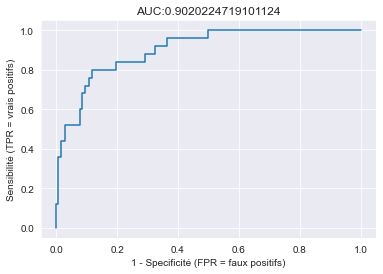

In [45]:
plt.plot(fpr, tpr)

plt.title('AUC:'+str(auc))
plt.xlabel('1 - Specificité (FPR = faux positifs)')
plt.ylabel('Sensibilité (TPR = vrais positifs)')
plt.show()

<div class="alert alert-info">

**Question 2**

> Quel seuil préconisez-vous pour avoir la meilleure sensibilité tout en gardant un *taux de faux positifs* (FPR) inférieur à 20% ?

</div>

In [46]:
seuil_cible = thresholds[fpr < 0.2].min()

print("Seuil (FPR < 20% & Max. sensibilité):", seuil_cible)

Seuil (FPR < 20% & Max. sensibilité): 0.11249645006423563


Voici les performances obtenues avec ce dernier seuil. Par definition, vous devriez observer une **specificité superieure à 80%**.

In [47]:
print_performance(predict_test, test.violator, 0.5)
print_performance(predict_test, test.violator, seuil)
print_performance(predict_test, test.violator, seuil_cible)

violator    
                   0   1
Predicted 0      177  22
          1        1   3

[Seuil: 0.5 ]
 Exactitude: 88.67 %
Sensibilité: 12.00 %
Spécificité: 99.44 %


violator    
                   0   1
Predicted 0      140   4
          1       38  21

[Seuil: 0.1 ]
 Exactitude: 79.31 %
Sensibilité: 84.00 %
Spécificité: 78.65 %


violator    
                   0   1
Predicted 0      143   5
          1       35  20

[Seuil: 0.11249645006423563 ]
 Exactitude: 80.30 %
Sensibilité: 80.00 %
Spécificité: 80.34 %


## 2. Exercices corrigés

Nous completons l'étude de la régression logistique en traitant deux exercices sur l'interpretation probabiliste du modèle.

### 2.1 Modèle logistique

Supposons que nous avons recueilli les données suivantes sur un groupe d'étudiants:

- $X_1$ = Heures passées à étudier pour un examen.
- $X_2$ = Moyenne générale.
- $Y$ = 1 si l'étudiant a obtenu la note maximale (A) à l'examen, 0 sinon. 

A partir des données disponibles, nous estimons un modèle logistique avec les coefficients ci-aprèes:

$$
\begin{bmatrix}
w_0\\
w_1\\
w_2\\
\end{bmatrix} 
= 
\begin{bmatrix}
-6\\
0.05\\
1
\end{bmatrix}
$$

<div class="alert alert-danger">

#### Question 1

> Estimer la probabilité qu'un étudiant ayant étudié pendant 40 heures et qui a une moyennegenerale de 3,5 obtienne la note maximale.

</div>

Le modèle logistique s'écrit de la manière suivante

$$
\textrm{Probabilité d'obtenir A} = \frac{1}{1 + \exp\big(-w_0 - w_1 \times \textrm{heures étudiées} - w_2 \times \textrm{moyenne}\big)}
$$

Par consequent, la réponse peut se deriver du calcul suivant, où nous avons remplacé les variables par les données du problème: 

$$
\begin{aligned}
\textrm{Probabilité d'obtenir A} &= \frac{1}{1+\exp(6- 0.05 \times 40 - 1 \times 3.5)}\\
&= \frac{1}{1+\exp(0.5)}\\
&= 0.3775
\end{aligned}
$$

<div class="alert alert-danger">

**Question 2:**

>  Combien d'heures l'étudiant de la question précédente devrait-il étudier pour avoir 50% de chances d'obtenir un A ?

</div>

La réponse s'appuie sur calcul suivant, qui correspond à inverser le modèle logistique:

$$
\begin{aligned}
\textrm{Probabilité d'obtenir A} &= \frac{1}{1 + \exp\big(-w_0 - w_1 \times \textrm{heures étudiées} - w_2 \times \textrm{moyenne}\big)}\\
0.5 &= \frac{1}{1+\exp(6- 0.05 \times \textrm{heures étudiées} - 1 \times 3.5)}\\
\frac{1}{0.5} &= 1 + \exp(6- 0.05 \times \textrm{heures étudiées} - 1 \times 3.5)\\
\log\left(\frac{1}{0.5} - 1\right) &= 6- 0.05 \times \textrm{heures étudiées} - 1 \times 3.5\\
\log(1)-6 + 3.5 &=  - 0.05 \times \textrm{heures étudiées}\\
\frac{2.5}{0.05} &= \textrm{heures étudiées}\\
50 &= \textrm{heures étudiées}
\end{aligned}
$$

### 2.2 Cotes (odds)

Ce problème est lié aux cotes (odds).

*Remarque:* Dans les jeux de hasard et des statistiques, la cote d'un événement est le ratio entre la probabilité que l'événement se produise et la probabilité qu'il ne se produise pas. On l'exprime souvent comme une paire de nombres où le dénominateur de la cote est ramené à 1. En particulier dans les paris et les jeux d'argent, la cote exprime le gain espéré dans le cas où l'événement sur lequel on a misé se réalise. Par exemple, une « cote de 4 contre 1 » traduit le fait qu'on gagnerait 4 fois sa mise. 

<div class="alert alert-danger">

**Question 1**

> En moyenne, quelle fraction des personnes ayant une cote de 0,37 d'un défaut de paiement sera effectivement en défaut ?

</div>

La réponse est basée sur la definition de cote.

$$
\begin{aligned}
\frac{p}{1-p} &= {\rm odds}\\
\frac{p}{1-p} &= 0.37\\
p &= 0.37 (1-p)\\
p + 0.37 p = 0.37\\
p = \frac{0.37}{1+0.37}\\
p = 0.2701
\end{aligned}
$$

<div class="alert alert-danger">

**Question 2**

> Supposons qu'une personne a 16% de chances d'un défaut de paiement. Quelle est la cote que cette personne sera en défaut ?

</div>

La réponse est toujours basée sur la definition de cote.

$$
{\rm odds} = \frac{p}{1-p} = \frac{0.16}{0.84} = 0.19
$$

## 3. The math behind logistic regression

Imagine that you have a set of two-dimensional points, where the y-coordinates are no longer continuous, but takes on **two fixed values** (e.g., 0 and 1):

$$\mathcal{S} = \big\{ \big(x^{(n)},y^{(n)}\big) \in \mathbb{R}\times\{0,1\} \;|\; n=1,\dots,N\big\}.$$

Each $\left(x^{(n)},y^{(n)}\right)$ can be visually represented as a point in 2D space, as shown below.

In [53]:
def draw_scatter(x, y):
    plt.scatter(x[y==0], y[y==0], c='b', marker='o', s=50)
    plt.scatter(x[y==1], y[y==1], c='r', marker='^', s=50)
    plt.xlabel("$x_p$")
    plt.ylabel("$y_p$")
    plt.grid()

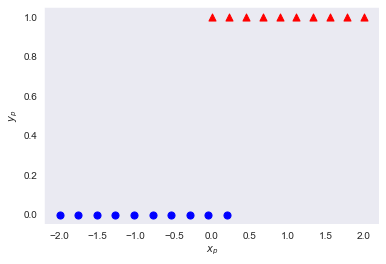

In [54]:
N = 10
x = np.concatenate([np.linspace(-2, 0.2, N), np.linspace(0, 2, N)])
y = np.concatenate([np.zeros(N), np.ones(N)]).astype(int)

draw_scatter(x,y)
plt.show()

### 3.1 Sigmoid function

How can we fit a regression model to the points $\left(x^{(n)},y^{(n)}\right)$ which are distributed around two values ?

Intuitively, it is obvious that a straight line will poorly fit such points. We rather need a function bounded in the interval $[0,1]$. Thankfully, such a function exists and it is defined as

$$
\sigma(z) = \frac{1}{1+e^{-z}}.
$$

This is called the **sigmoid** function.

<div class="alert alert-success">

**Exercise 1**

> Implement the sigmoid function defined above.

</div>

In [55]:
def sigmoid(z):
    """Compute the sigmoid of the elements in z"""
    
    ### START CODE HERE ###
    s = 1 / (1 + np.exp(-z))
    ### END CODE HERE ###
    
    return s

In [56]:
z = np.array([1, 2, 3])
s = sigmoid(z)

print('sigmoid:', s)

sigmoid: [0.73105858 0.88079708 0.95257413]


**Expected Output**: 

<table>
    <tr> 
        <td> sigmoid </td> 
        <td> [0.73105858,  0.88079708,  0.95257413] </td> 
    </tr>
</table> 

In [57]:
np.testing.assert_almost_equal(s, [0.73105858, 0.88079708, 0.95257413])

Here is what the sigmoid function looks like.

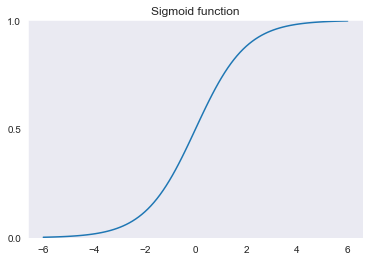

In [58]:
t = np.linspace(-6,6,100)
s = sigmoid(t)

plt.plot(t,s)
plt.yticks([0,0.5,1])
plt.ylim([0,1])
plt.grid()
plt.title("Sigmoid function")
plt.show()

### 3.2 Logistic regression

To enable data fitting with the sigmoid function, we can compose it with a linear model, yielding the **logistic model**

$$
f_w(x) = \sigma(w_0 + w_1 x) = \frac{1}{1+e^{-(w_0 + w_1 x)}}.
$$

Of course, this model can be easily extended to the case when the input is vector rather than a scalar

$$
f_w({\bf x}) = \sigma(w_0 + w_1 x_1 + \dots + w_Q x_Q) = \frac{1}{1+e^{-(w_0 + w_1 x_1 + \dots + w_Q x_Q)}}.
$$

<div class="alert alert-success">

**Exercise 2**

> Implement the logistic model defined above.

</div>

In [59]:
def logistic(w, x):
    """Evaluate the logistic model"""
    
    ### START CODE HERE ###
    
    # compute 'z = w[0] + w[1] * x'
    z = w[0] + w[1:] * x
    
    # compute the sigmoid of z
    s = sigmoid(z)
    
    ### END CODE HERE ###
    
    return s

In [60]:
w = [0.5, 1.5]
t = np.array([-2, 2, 0.5])
p = logistic(w, t)

print('logistic:', p)

logistic: [0.07585818 0.97068777 0.77729986]


**Expected Output**: 

<table>
    <tr> 
        <td> logistic </td> 
        <td> [0.07585818, 0.97068777, 0.77729986] </td> 
    </tr>
</table> 

In [61]:
np.testing.assert_almost_equal(p, [0.0758582, 0.9706878, 0.7772999])

The task of estimating the weights $w=(w_0,w_1)$ from a binary classification dataset is what we refer to as **logistic regression**.

The widget below shows that it is possible to adapt the logistic model $f_w(x)$ by changing its weights. Move the sliders to interact with the plot. 

In [62]:
def draw_line(w, x, y=None):
    t = np.linspace(-2.5,2.5,100)
    p = logistic(w, t)
    plt.plot(t, p, 'g', lw=2)
    plt.plot(np.vstack([x,x]),np.vstack([logistic(w,x),y]), '--k', alpha=0.5)

In [63]:
def update_plot(a, b):
    draw_scatter(x, y)
    draw_line([b,a], x, y)
    plt.axis([-2.5,2.5,-0.1,1.1])

a_slider = widgets.FloatSlider(1, min=-15, max=15, step=0.0001, description='$w_1$', continuous_update=False)
b_slider = widgets.FloatSlider(0, min=-10, max=10, step=0.0001, description='$w_0$', continuous_update=False)
widgets.interact(update_plot, a=a_slider, b=b_slider)

plt.show()

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='$w_1$', max=15.0, min=-15.0…

### 3.3 Logarithmic error

How can we possibly find the logistic model that best fits the points $(x^{(n)},y^{(n)})$? According to the previous remark, we need to tune the weigths $w=(w_0,w_1)$ so that the following approximations hold as tight as possible (for every $n\in\{1,\dots,N\}$):

$$ %\sigma(w_0 + w_1 x^{(n)}) 
f_w(x^{(n)}) \approx y^{(n)}. $$

Another way of stating the above is to say that the error between the prediction $p^{(n)} = f_w(x^{(n)})$ and the real output $y^{(n)}$ must be small. 

There is more than one way to measure the error between two scalar quantities. The squared error works universally, regardless of the values involved. However, because we know that the output is a binary value $y\in\{0,1\}$  and the logistic model yields a bounded value $p \in \left]0,1\right[$, it is reasonable to ask if we cannot compute a more appropriate error that is customized to deal with just such values. The answer is positive. There exists the **log-error**, defined as

$$
\textrm{log-error}(p, y) = 
\begin{cases}
-\log(p) &\quad \text{if} \; y = 1 \\
-\log(1-p) &\quad\text{if} \; y = 0. \\
\end{cases}
$$

The log-error is always non-negative and attains its minimum value at $0$.

<div class="alert alert-success">

**Exercise 3** 

> Implement the log-error function defined above.

</div>

**Hint:** A vectorized implementation of the log-error is as follows:

$$ \textrm{log-error}(p, y) = - y \log(p) - (1-y) \log(1-p) $$

where the products are meant element-wise.

In [67]:
def log_error(p, y):
    """Compute the log-error between two arrays"""
    
    ### START CODE HERE ###
    
    # compute 'y * log(p)'
    log1 = - y * np.log(p)
    
    # compute '(1-y) * log(1-p)'
    log2 = (1 - y) * np.log(1 - p)
    
    # compute the log-error
    error = log1 - log2
    
    ### END CODE HERE ###
    
    return error

In [68]:
p = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
t = np.array([0, 1, 0, 0, 1])
e = log_error(p, t)

print('log-error:', e)

log-error: [0.10536052 1.2039728  0.69314718 1.2039728  0.10536052]


**Expected Output**: 

<table>
    <tr> 
        <td> log-error </td> 
        <td> [0.10536052, 1.2039728, 0.69314718, 1.2039728, 0.10536052] </td> 
    </tr>
</table> 

In [69]:
np.testing.assert_almost_equal(e, [0.10536052, 1.2039728, 0.69314718, 1.2039728, 0.10536052])

Here is what the log-error looks like.

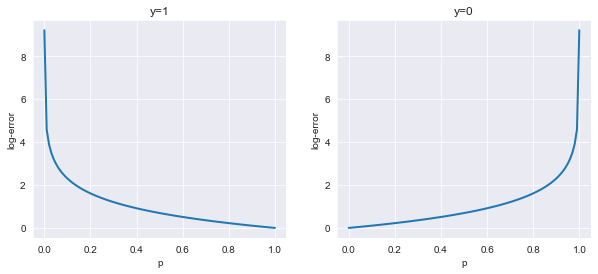

In [70]:
p  = np.linspace(0.0001,.9999,100)
y1 = np.ones_like(p)
y0 = np.zeros_like(p)

fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(p, log_error(p,y1), lw=2)
ax[0].set(title="y=1", xlabel='p', ylabel='log-error')

ax[1].plot(p, log_error(p,y0), lw=2)
ax[1].set(title="y=0", xlabel='p', ylabel='log-error')

plt.show()

### 3.4 Logistic cost function

Let's see how the log-error can be used to tune the weights of our logistic model $f_w(x^{(n)})$. As the output is binary, we can distinguish two case.

- When $y^{(n)} = 1$, the log-error decreases when the prediction $f_w(x^{(n)})$ approaches the value $1$:

$$
\begin{aligned}
f_w(x^{(n)})\approx 1 &\quad\Leftrightarrow\quad -\log\big(f_w(x^{(n)})\big) \approx -\log(1) \quad\Leftrightarrow\quad \textrm{log-error}\big(f_w(x^{(n)}), 1\big)\approx 0.
%f_w(x^{(n)})\approx 0 &\quad\Leftrightarrow\quad -\log\big(f_w(x^{(n)})\big) \approx -\log(0) \quad\Leftrightarrow\quad \textrm{log-error}\big(f_w(x^{(n)}), 1\big)\to +\infty.
\end{aligned}
$$

- When $y^{(n)} = 0$, the log-error decreases when the prediction $f_w(x^{(n)})$ approaches the value $0$:

$$ 
\begin{aligned}
f_w(x^{(n)})\approx 0 &\quad\Leftrightarrow\quad -\log\big(1-f_w(x^{(n)})\big) \approx -\log(1) \quad\Leftrightarrow\quad \textrm{log-error}\big(f_w(x^{(n)}), 0\big)\approx 0.
%f_w(x^{(n)})\approx 1 &\quad\Leftrightarrow\quad -\log\big(1-f_w(x^{(n)})\big) \approx -\log(0) \quad\Leftrightarrow\quad \textrm{log-error}\big(f_w(x^{(n)}), 0\big)\to +\infty.
\end{aligned}
$$

 
Because we desire that all the log-errors are small, we can take their average and form what is called the **logistic cost function**:

$$ J(w) = \frac{1}{N}\sum_{n=1}^N \textrm{log-error}\Big(f_w(x^{(n)}), y^{(n)}\Big).$$

This is a function that measures how well a logistic model fits the points $\left(x^{(n)},y^{(n)}\right)$, given a specific choice for the weigths $w=(w_0,w_1)$.

---
#### Remark

You will often see the logistic cost function written as follows:

$$ J(w) = \frac{1}{N}\sum_{n=1}^N \log\Big(1+e^{-(2y^{(n)}-1)(w_0+w_1 x^{(n)})}\Big).$$

The two expressions are exactly the same, except that the latter is more robust numerically.

<div class="alert alert-success">

**Exercise 4** 

> Implement the logistic cost function defined above.

</div>

In [71]:
def logistic_cost(w, x, y):
    """Evaluate the logistic cost function"""
    
    ### START CODE HERE ###
    
    # Compute the predictions with your function 'logistic()'
    preds = logistic(w, x)
    
    # Compute the log-errors with your function 'log_error()'
    errors = log_error(preds, y)
    
    # Compute the mean of log-errors
    cost = errors.mean()
    
    ### END CODE HERE ###
    
    return cost

In [72]:
w = [0.5, 1.5]
c = logistic_cost(w, x, y)

print('cost:', c)

cost: 0.3222354881901067


**Expected Output**: 

<table>
    <tr> 
        <td> cost </td> 
        <td> 0.3222354881901067 </td> 
    </tr>
</table> 

In [73]:
np.testing.assert_almost_equal(c, 0.3222354881901067, decimal=6)

The widget below illustrates that the best values for the weigths $w=(w_0,w_1)$ are located at the lowest point of the cost function  $J(w)$.

In [74]:
def draw_surface(ax, X, Y, Z):
    ax.plot_surface(X, Y, Z, norm=LogNorm(),alpha=.9,cmap=plt.cm.jet,rstride=3,cstride=3,linewidth=0.2,edgecolor = 'k')
    ax.set_xlabel("w_1")
    ax.set_ylabel("w_0")
    ax.set_title("Cost function J(w)", fontsize=15, color='k')
    
def draw_contours(ax, X, Y, Z):
    lev = np.logspace(-0.9,0,10)
    cs = ax.contour(X, Y, Z, levels=lev, norm=LogNorm(), alpha=.4, colors = 'k')
    ax.clabel(cs, inline=1, fontsize=10)
    ax.contourf(X, Y, Z, levels=lev, norm=LogNorm(), cmap=plt.cm.jet, alpha=.4)
    ax.set_xlabel("$w_1$")
    ax.set_ylabel("$w_0$")
    
def draw_point(ax, w, lims=None):
    if len(w) < 3:
        ax.plot(w[0], w[1], '*', color='k', markersize=20, alpha=0.7, markeredgewidth=2, markeredgecolor='w')
        ax.plot([w[0],w[0]], [lims[0],w[1]], '--k', alpha=0.5)
        ax.plot([lims[1],w[0]], [w[1],w[1]], '--k', alpha=0.5)
    else:
        ax.plot([w[0]],[w[1]],[w[2]], '*', color='k', markersize=20, alpha=0.7, markeredgewidth=2, markeredgecolor='w')

In [75]:
w0_lim = [-5,5]
w1_lim = [ 4,12]
a_values, b_values = np.meshgrid(np.arange(w1_lim[0],w1_lim[1],0.1), np.arange(w0_lim[0],w0_lim[1],0.1))
w_values = np.stack([b_values.flatten(), a_values.flatten()],axis=1)
J_values = np.log(1+np.exp(-(2*y-1)*(w_values[:,[0]] + w_values[:,[1]]*x))).mean(axis=1).reshape(a_values.shape)

def update_plot(a, b):
    fig = plt.figure(figsize=(20,5))
    fig.add_subplot(131)
    draw_scatter(x, y)
    draw_line([b,a], x, y)
    ax = fig.add_subplot(132, projection='3d', elev=25, azim=-70)
    draw_surface(ax, a_values, b_values, J_values)
    cost = np.log(1+np.exp(-(2*y-1)*(b + a*x))).mean()
    draw_point(ax, [a,b,cost])
    ax = fig.add_subplot(133)
    draw_contours(ax, a_values, b_values, J_values)
    draw_point(ax, [a,b], [w0_lim[0],w1_lim[0]])
    ax.set_title("Cost of w = {:2.4f}".format(cost), fontsize=15, color='k')
    
a_slider = widgets.FloatSlider(4.5, min=w1_lim[0]+0.1, max=w1_lim[1], step=0.0001, description='$w_1$', continuous_update=False)
b_slider = widgets.FloatSlider(2.5, min=w0_lim[0]+0.1, max=w0_lim[1], step=0.0001, description='$w_0$', continuous_update=False)
widgets.interact(update_plot, a=a_slider, b=b_slider)

plt.show()

interactive(children=(FloatSlider(value=4.5, continuous_update=False, description='$w_1$', max=12.0, min=4.1, …

### 3.5 Gradient descent

The "correct" weights for the logistic model can be computed by optimizing the logistic cost function, namely

$$
\operatorname*{minimize}_{w} \; J(w).
$$

Inspecting the overall shape of the cost function helps determine the appropriate optimization method to be used. In this case, it is easy to check that the function $J(w)$ is **convex** with respect to the weights $w$. Convexity means that the function curvature is always positive. Because of this, we are guaranteed that optimization methods will always find the global minimum of this cost function.

Since the function is differentiable, we can employ **gradient descent** to find a solution to the above problem. This method updates the current iterate $w^{[t]}$ in an iterative fashion for $t=0,1,\dots,T$ steps, using the following formula at each iteration:

$$
w^{[t+1]} = w^{[t]} - \alpha \nabla J\big(w^{[t]}\big),
$$

where $\alpha$ is the so-called **step-size** parameter. The gradient of the logistic cost function is equal to

$$
\nabla J\big(w\big) = 
\begin{bmatrix} 
\frac{\partial J(w)}{\partial w_0}\\
\frac{\partial J(w)}{\partial w_1}
\end{bmatrix}
$$

where

$$
\frac{\partial J(w)}{\partial w_0} = \frac{1}{N}\sum_{n=1}^N \big(f_w(x^{(n)}) - y^{(n)}\big)
\qquad\qquad
\frac{\partial J(w)}{\partial w_1} = \frac{1}{N}\sum_{n=1}^N x^{(n)} \big(f_w(x^{(n)}) - y^{(n)}\big).
$$

<div class="alert alert-success">

**Exercise 5**

> Use the above formula to implement the gradient of the logistic cost function.

</div>

In [76]:
def logistic_gradient(w, x, y):
    """Compute the gradient of the logistic cost function"""
    
    grad = np.zeros(2)
    
    ### START CODE HERE ###
    
    # Compute the predictions with your function 'logistic()'
    preds = logistic(w, x)
    
    # Compute the difference between 'preds' and 'y'
    diffs = preds - y
    
    # Compute the gradient w.r.t. w_0
    grad[0] = np.mean(diffs)
    
    # Compute the gradient w.r.t. w_1
    grad[1] = np.mean(x * diffs)
    
    ### END CODE HERE ###
    
    return grad

In [77]:
w = [0.5, 1.5]
g = logistic_gradient(w, x, y)

print('gradient:', g)

gradient: [ 0.09119623 -0.12276723]


**Expected Output**: 

<table>
    <tr> 
        <td> gradient </td> 
        <td> [0.09119623, -0.12276723] </td> 
    </tr>
</table> 

In [78]:
np.testing.assert_almost_equal(g, [0.09119623, -0.12276723], decimal=6)

With the gradient sorted out, it is straightforward to optimize the logistic cost function via gradient descent.

In [79]:
w0 = [0.5, 1.5]
alpha = 10
epochs = 500

w = w0
for t in range(epochs):
    w = w - alpha * logistic_gradient(w, x, y)
    
print(w)

[-0.68247682  7.43069823]


The figure below displays the solution computed by gradient descent.

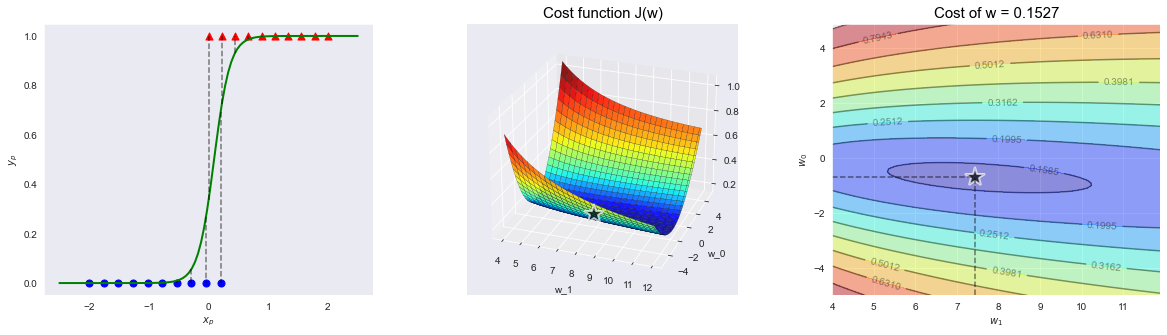

In [80]:
update_plot(w[1], w[0])